In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, PathPatch, Rectangle
import matplotlib.patheffects as pe
import xml.etree.ElementTree as ET
from scipy.stats import chi2
# Plotting style
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('font', size=16)

main_colors = ["#e96859", "#9546ca", "#00cc00", "#80bfff"]

import csv

def load_csv(filename):
    with open(filename) as csvfile:
        file = csv.reader(csvfile)
        x = []; y = []
        for row in file:
            x.append(float(row[0]))
            y.append(float(row[1]))
    return np.asarray(x), np.asarray(y)



false = ["", " ", "\n", "\t"]
def get_data(xml_file):
    '''Outputs numerical data (x, y) from xml file in format provided by 
    http://dmtools.brown.edu/
    
    Credit to my friend David Taylor for helping me write this function'''
    
    # open xlm file
    raw2 = ET.parse(xml_file)
    
    # get data
    data_as_string = raw2.findall('data-values')[0].text
    
    # get rescaling factors
    y_rescale = float(raw2.findall('y-rescale')[0].text)
    x_rescale = float(raw2.findall('x-rescale')[0].text)
    
    # Take of brackets at each end
    data_as_string = data_as_string[2:-2].replace("\n", "").replace("]", "")

    x_data = []
    y_data = []

    # Split into x and y data
    for pair in data_as_string.split(";"):
        split = pair.split()
        # remove unwanted characters
        split = [x for x in split if x not in false]
        x, y = split
        
        # rescale and append
        x_data.append(float(x)*x_rescale)
        y_data.append(float(y)*y_rescale)
        
    return x_data, y_data

def loadBinary(fileName):
    masses = []
    sigmas = []
    likelihoods = []
    with open(fileName) as file:
        lines = file.read().split("\n")[1:]
        for line in lines:
            newMass, logSig, likelihood = line.split("\t")
            masses.append(float(newMass))
            sigmas.append(10**(float(logSig)))
            likelihoods.append(float(likelihood))

    masses = np.asarray(masses).reshape(500, 500)
    sigmas = np.asarray(sigmas).reshape(500, 500)
    likelihoods = np.asarray(likelihoods).reshape(500, 500)
    return masses, sigmas, likelihoods

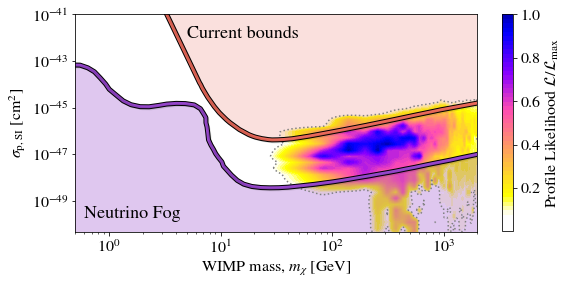

In [2]:
from scipy.interpolate import interp1d

mass_neu, sigma_neu = load_csv("data/neutrinoFog.csv")

path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal(), 
              pe.SimpleLineShadow(alpha = 0.1, offset=(2,-2))]

fig = plt.figure(figsize = (9,4))
ax = fig.add_subplot(111)
masses, sigmas, likelihoods = loadBinary("data/MSSM7_105_217_like2D.ct2")    
for i in range(3):
    col = ax.contourf(masses, sigmas, likelihoods, vmin = 0.08, vmax = 1.2, levels = 50, cmap = "gnuplot2_r")#
    
plt.contour(col, levels=[10**(-2.27886867 /2)], colors='gray', linewidths = 1.5, linestyles = ':')

ax.set_xscale("log")
ax.set_yscale("log")
#ax.legend(loc=1, frameon=False, prop={"size":14})

masses, sigma = get_data("data/xenon1T.xml")

xenon = interp1d(np.log10(masses), np.log10(sigma), bounds_error=False, fill_value="extrapolate")
masses2 = np.logspace(1e-1, 3.5, 1000)

plt.loglog(masses2, 10**xenon(np.log10(masses2)), lw=3, label = "XENON1T", color = main_colors[0], path_effects=path_effects)
plt.fill_between(masses2, 10**xenon(np.log10(masses2)), 1, color = main_colors[0], alpha = 0.2)


ax.loglog(mass_neu, sigma_neu, lw = 3, color = main_colors[1],  path_effects=path_effects)
ax.fill_between(mass_neu, sigma_neu, 0, color = main_colors[1], alpha = 0.3)

plt.annotate("Current bounds", (5, 1e-42), rotation = 0, size = 18)
plt.annotate("Neutrino Fog", (6e-1, 2e-50), rotation = 0, size = 18)
plt.axis([5e-1, 2000, 5e-51, 1e-41])
plt.ylabel("$\sigma_{\mathrm{p, SI}}$ [cm$^2$]")
plt.xlabel("WIMP mass, $m_{\chi}$ [GeV]")
colax = plt.colorbar(col, ticks=[0.2, 0.4, 0.6, 0.8, 1], label = "Profile Likelihood $\mathcal{L}/\mathcal{L}_{\mathrm{max}}$")

fig.savefig("wimp_dd.pdf", bbox_inches='tight')